In [427]:
from pathlib import Path

import dill as pickle
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

pd.set_option("display.max_columns", None)  # Display all columns

plt.style.use("ggplot")

In [428]:
raw_data_dir = Path(Path.cwd().parent, "data", "raw")
interim_data_dir = Path(Path.cwd().parent, "data", "interim")
processed_data_dir = Path(Path.cwd().parent, "data", "processed")
input_fname = Path(raw_data_dir, "dataset.csv")
df = pd.read_csv(input_fname, low_memory=False)

# Train Test Split
Before I undertake any data cleaning or transformation I'll put aside a test set for final model performance. 
I intend to use cross validation during training to evaluate the model iteratively, so don't need to set aside a validation set at this point. 

Due to the high imbalance present in the target feature, seen in the previous notebook, it is important the train test split is stratified on the target feature. 

In [429]:
perc_pos_prior = 100 * (
    df["CHURN"].value_counts()[1] / len(df)
)  # % positive target feature prior to splitting
perc_pos_prior

0.67

In [430]:
X = df.drop("CHURN", axis=1)
y = df["CHURN"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)  # 80:20 train:test split

In [431]:
X_train = X_train.reset_index(drop=True)

In [432]:
y_train_unique, y_train_counts = np.unique(y_train, return_counts=True)
y_test_unique, y_test_counts = np.unique(y_test, return_counts=True)

perc_pos_post_train = y_train_counts[1] / (sum(y_train_counts)) * 100
perc_pos_post_test = y_train_counts[1] / (sum(y_train_counts)) * 100

print(f"% of positive target features in y_train: {perc_pos_post_train } %")
print(f"% of positive target features in y_train: {perc_pos_post_test} %")

assert np.isclose(a=perc_pos_post_train, b=perc_pos_prior)
assert np.isclose(a=perc_pos_post_test, b=perc_pos_prior)

% of positive target features in y_train: 0.67 %
% of positive target features in y_train: 0.67 %


Now we have a stratified train test split we can put aside the test set for future use. 

In [433]:
X_train.to_pickle(Path(interim_data_dir, "X_train.pkl"))
y_train.to_pickle(Path(interim_data_dir, "y_train.pkl"))

X_test.to_pickle(Path(interim_data_dir, "X_test.pkl"))
y_test.to_pickle(Path(interim_data_dir, "y_test.pkl"))

# Cleaning and Transformation

In [434]:
X_train.head()

,SALESFORCEACCOUNTID,ACCOUNTING_MONTH,RENEWAL_MONTH,CONTRACT_START_DATE,REGION,SECTOR,TENURE_MONTHS,DNB_GLOBAL_SALES_REVENUE,DNB_GLOBAL_EMPLOYEE_COUNT,CONTRACT_LENGTH,ARR,SEATS,COMPETITOR_SEATS,DETECTEDSEATSCOUNT,PRODUCT_ONE,PRODUCT_TWO,PRODUCT_THREE,PRODUCT_FOUR,PRODUCT_FIVE,PRODUCT_SIX,PRODUCT_SEVEN,PRODUCT_EIGHT,PRODUCT_NINE,PRODUCT_TEN,PRODUCT_ELEVEN,PRODUCT_TWELVE,PRODUCT_THIRTEEN,PRODUCT_FOURTEEN,PRODUCT_FIFTEEN,PRODUCT_SIXTEEN,PRODUCT_SEVENTEEN,PRODUCT_EIGHTEEN,PRODUCT_NINETEEN,PRODUCT_TWENTY,PRODUCT_TWENTYONE,PRODUCT_TWENTYTWO,PRODUCT_TWENTYTHREE,LICENSINGSPECIALIST_CHANGE,SALESREP_CHANGE,UPSELLMANAGER_CHANGE,ACCOUNTMANAGER_CHANGE,CHURN_RISK_DISCUSSION,CUSTOMER_HEALTH_CHECK,CS_EVENT_ATTENDED,CROSS_SELL_RECENCY,SEATS_DOWNSELL_RECENCY,PRODUCT_DOWNSELL_RECENCY,SEATS_UPSELL_RECENCY,PCT_PRODUCT_TWO_ENABLED,PCT_PRODUCT_THREE_ENABLED,PCT_PRODUCT_FOUR_ENABLED,PCT_PRODUCT_FIVE_ENABLED,PCT_PRODUCT_SIX_ENABLED,PCT_PRODUCT_NINE_ENABLED,PCT_PRODUCT_TWO_BEST_PRACTICE,PCT_PRODUCT_THREE_BEST_PRACTICE,PCT_PRODUCT_FOUR_BEST_PRACTICE,CUSTOMER_BEHAVIOUR_ONE,CUSTOMER_BEHAVIOUR_TWO,CUSTOMER_BEHAVIOUR_THREE,CUSTOMER_BEHAVIOUR_FOUR,CUSTOMER_BEHAVIOUR_FIVE,CUSTOMER_BEHAVIOUR_SIX,CUSTOMER_BEHAVIOUR_SEVEN,CUSTOMER_BEHAVIOUR_EIGHT,CUSTOMER_BEHAVIOUR_NINE,CUSTOMER_BEHAVIOUR_TEN,CUSTOMER_BEHAVIOUR_ELEVEN,MAX_SUPPORT_CASE_DAYSTOCLOSE,MAX_SUPPORT_CASE_TIMETOFIRSTRESPONSE,AVG_SUPPORT_CASE_PRIORITY_SCORE,SUM_SEVERE_CASES,SUM_HIGH_CASES,SUM_MEDIUM_CASES,SUM_LOW_CASES,SUM_STANDARD_CASES,SUPPORT_CASE_NUMBEROFSLABREACHES,BACKLOG,SURVEY_AVG_CXI_SCORE,SURVEY_AVG_NPS_SCORE,SURVEY_AVG_CASE_MOOD_SCORE
0,0011N00001aYqEZQA0,2021-06-01 00:00:00+00:00,2022-05-01T00:00:00Z,2021-05-04T00:00:00Z,USA,Finance,52,29283931.0,234.0,364,20418.74,220,0,0.709091,1,1,0,1,1,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,23,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,NaN,NaN,NaN
1,0011N00001hBZuAQAW,2023-01-01 00:00:00+00:00,2023-12-01T00:00:00Z,2022-12-04T00:00:00Z,UKI,Professional Services,107,260626374.0,2048.0,364,81661.54,800,0,0.736250,1,1,1,1,1,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,12,2,0,0,0,0,0,0,1,1,0,0,14216,16,0,0,2425,5,0,0,109,1,0,0,0.0,0,0,0,0,1,0,3,NaN,NaN,NaN
2,0011N00001aYhHiQAK,2022-02-01 00:00:00+00:00,2022-06-01T00:00:00Z,2021-06-16T00:00:00Z,UKI,"Travel, Hospitality & Catering",47,NaN,NaN,364,4992.46,60,0,1.016667,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,7,0,8,0,0,0,0,0,0,1,0,0,0,380854,0,0,0,504,0,0,0,14,1,0,0,0.0,0,0,0,0,0,0,1,NaN,NaN,NaN
3,0011N00001aYqGgQAK,2021-08-01 00:00:00+00:00,2021-10-01T00:00:00Z,2020-10-30T00:00:00Z,USA,Finance,81,439685674.0,1033.0,364,153947.01,2562,0,0.920375,1,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,3,0,4,0,21,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,3,0,30.0,0,0,0,0,1,1,1,NaN,NaN,NaN
4,0011N00001aYhCzQAK,2023-04-01 00:00:00+00:00,2023-08-01T00:00:00Z,2022-08-31T00:00:00Z,UKI,Finance,55,12863428.0,36.0,364,3599.11,49,0,0.000000,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,7,0,8,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,NaN,NaN,NaN


In [435]:
X_train.columns

Index(['SALESFORCEACCOUNTID', 'ACCOUNTING_MONTH', 'RENEWAL_MONTH',
       'CONTRACT_START_DATE', 'REGION', 'SECTOR', 'TENURE_MONTHS',
       'DNB_GLOBAL_SALES_REVENUE', 'DNB_GLOBAL_EMPLOYEE_COUNT',
       'CONTRACT_LENGTH', 'ARR', 'SEATS', 'COMPETITOR_SEATS',
       'DETECTEDSEATSCOUNT', 'PRODUCT_ONE', 'PRODUCT_TWO', 'PRODUCT_THREE',
       'PRODUCT_FOUR', 'PRODUCT_FIVE', 'PRODUCT_SIX', 'PRODUCT_SEVEN',
       'PRODUCT_EIGHT', 'PRODUCT_NINE', 'PRODUCT_TEN', 'PRODUCT_ELEVEN',
       'PRODUCT_TWELVE', 'PRODUCT_THIRTEEN', 'PRODUCT_FOURTEEN',
       'PRODUCT_FIFTEEN', 'PRODUCT_SIXTEEN', 'PRODUCT_SEVENTEEN',
       'PRODUCT_EIGHTEEN', 'PRODUCT_NINETEEN', 'PRODUCT_TWENTY',
       'PRODUCT_TWENTYONE', 'PRODUCT_TWENTYTWO', 'PRODUCT_TWENTYTHREE',
       'LICENSINGSPECIALIST_CHANGE', 'SALESREP_CHANGE', 'UPSELLMANAGER_CHANGE',
       'ACCOUNTMANAGER_CHANGE', 'CHURN_RISK_DISCUSSION',
       'CUSTOMER_HEALTH_CHECK', 'CS_EVENT_ATTENDED', 'CROSS_SELL_RECENCY',
       'SEATS_DOWNSELL_RECENCY', 'PRODUC

## Cleaning


### Handling missing data

In [436]:
X_train.isnull().sum().sort_values().tail(10)

PRODUCT_TWELVE                    0
PRODUCT_ELEVEN                    0
PRODUCT_SEVENTEEN                 0
ACCOUNTING_MONTH                  0
SECTOR                        12142
DNB_GLOBAL_EMPLOYEE_COUNT     30486
DNB_GLOBAL_SALES_REVENUE      30486
SURVEY_AVG_CASE_MOOD_SCORE    78040
SURVEY_AVG_CXI_SCORE          79057
SURVEY_AVG_NPS_SCORE          79717
dtype: int64

<Axes: >

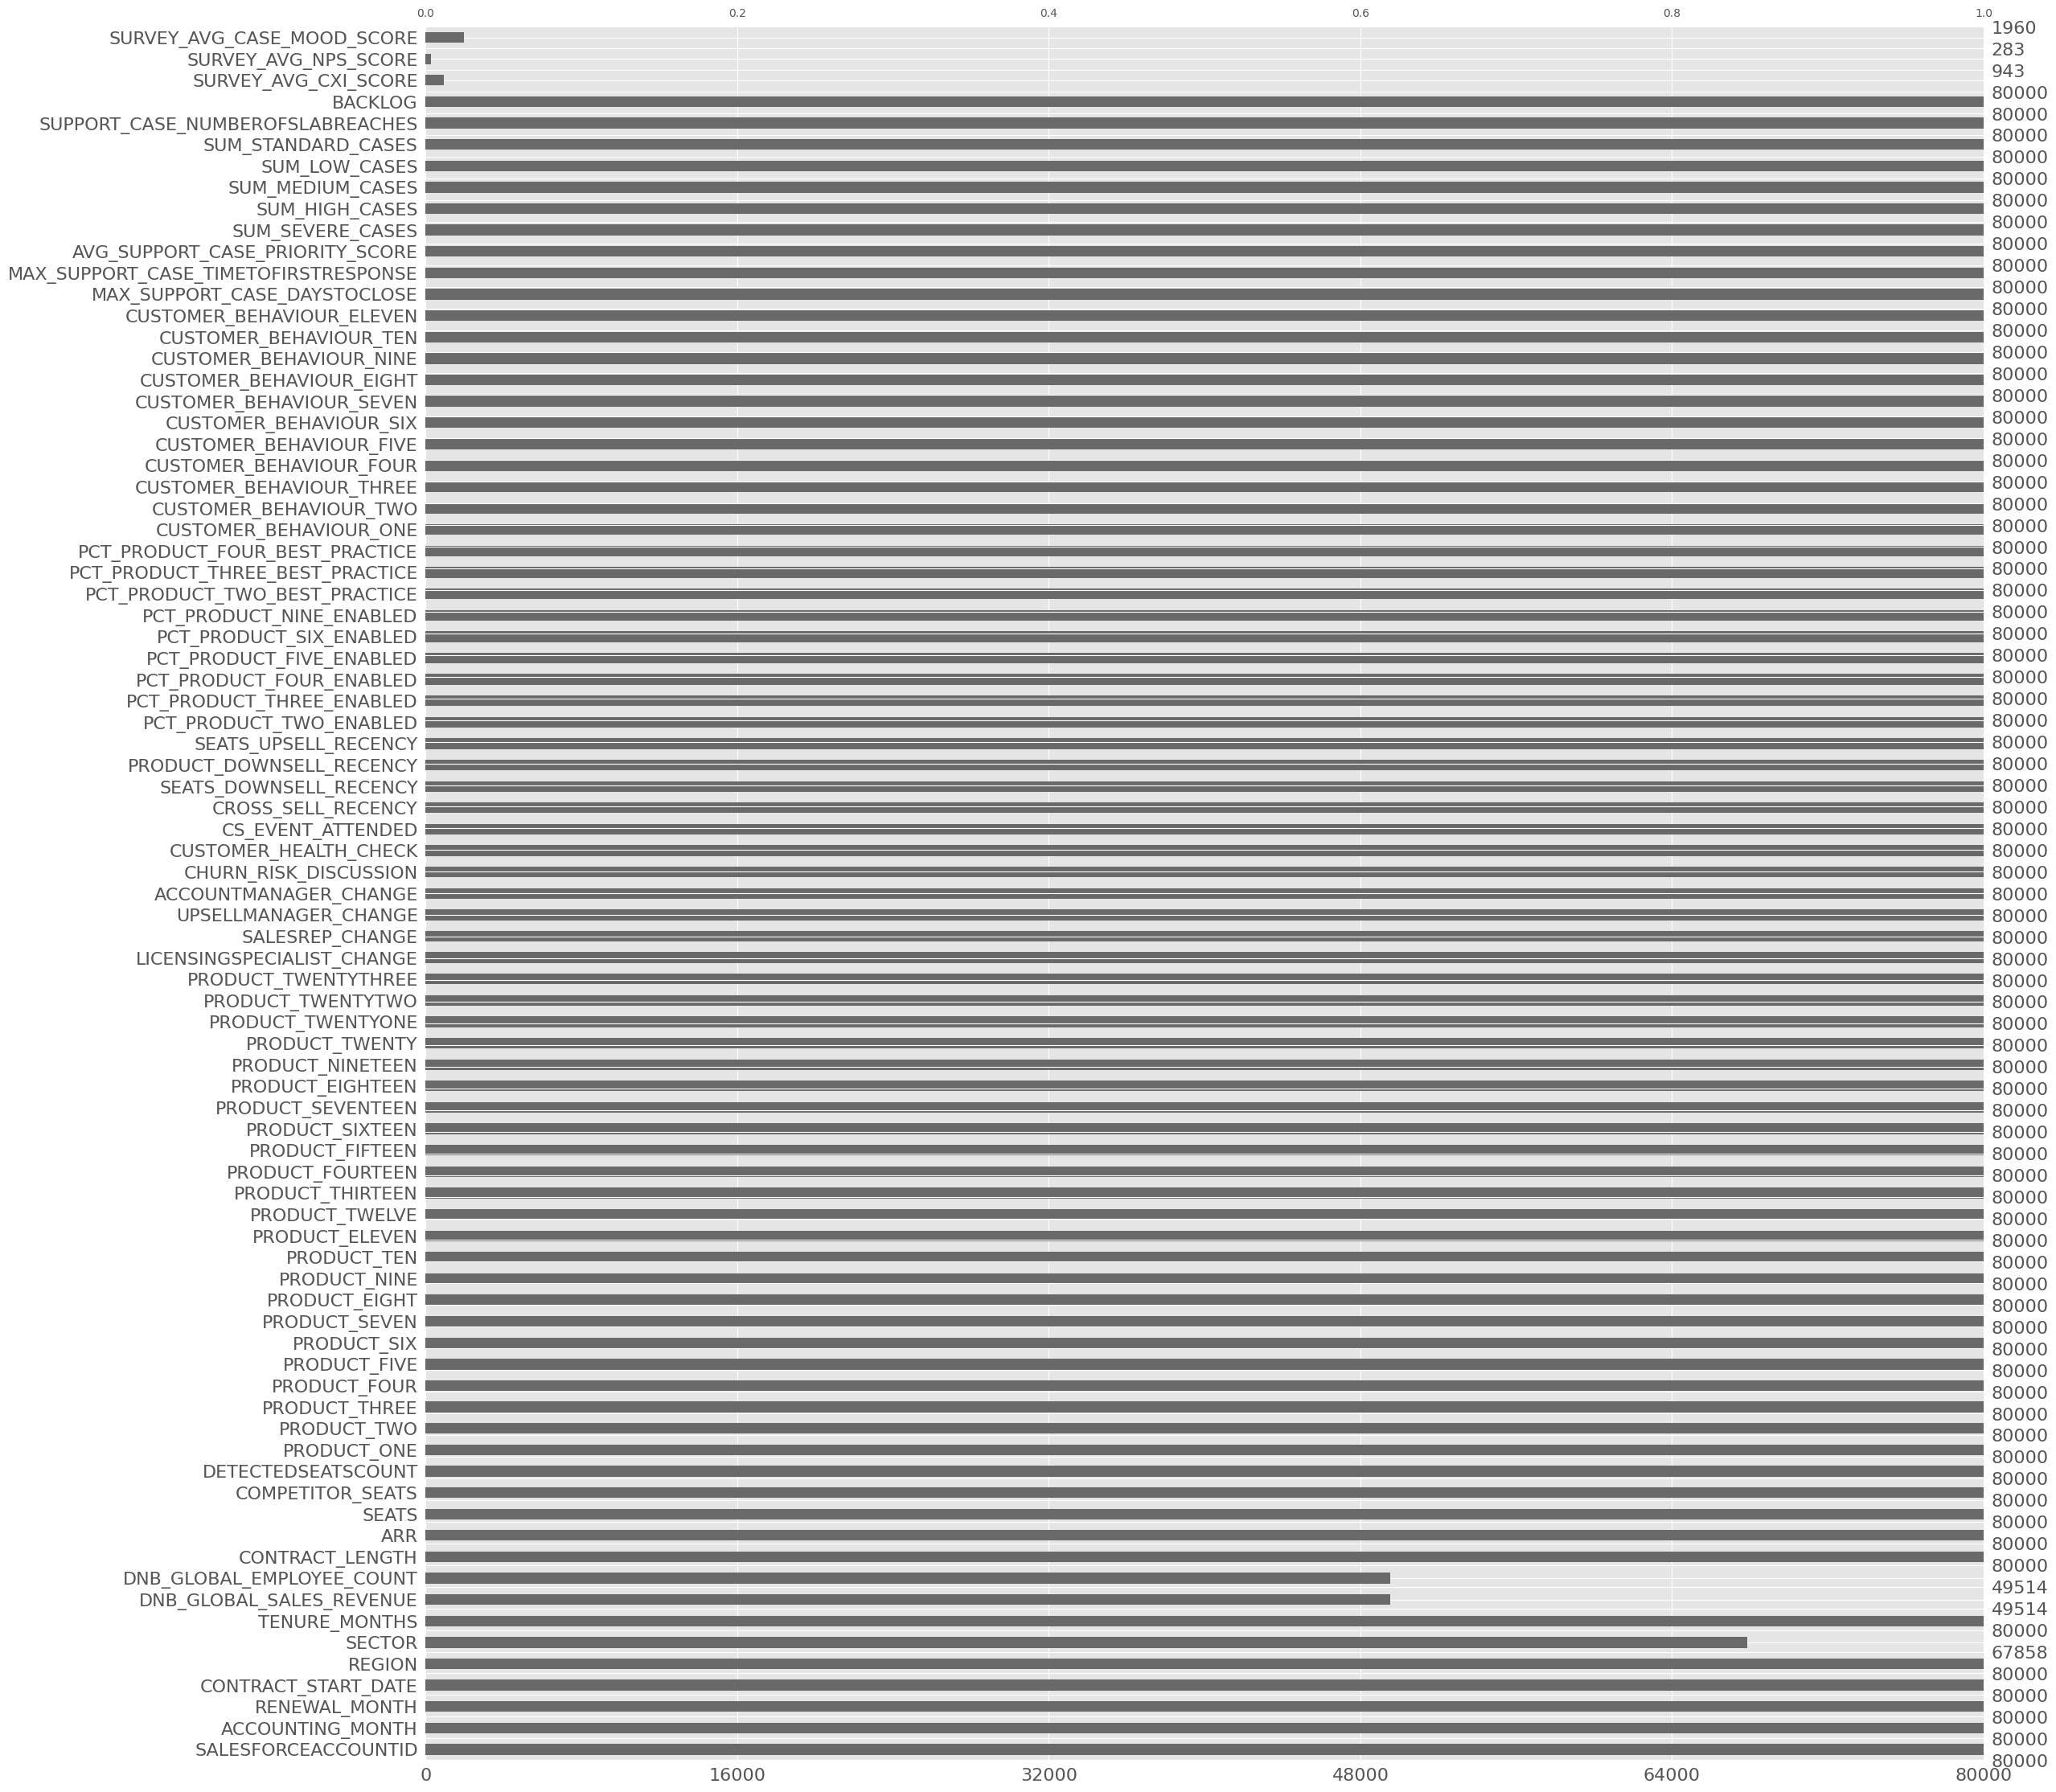

In [437]:
# Count plot of missing data
msno.bar(X_train)

"SURVEY_AVG_CXI_SCORE", "SURVEY_AVG_NPS_SCORE", and "SURVEY_AVG_CASE_MOOD_SCORE" have very little data, only around 360 - 2500 values for the entire dataset (100,000 points). Due to the severe lack of data here it makes most sense to just drop these columns from the dataset. 

In [438]:
X_train = X_train.drop(
    ["SURVEY_AVG_CXI_SCORE", "SURVEY_AVG_NPS_SCORE", "SURVEY_AVG_CASE_MOOD_SCORE"],
    axis=1,
)

The other columns with missing data - "SECTOR", "DNB_GLOBAL_EMPLOYEE_COUNT", and "DNB_GLOBAL_SALES_REVENUE" have more available data (around 65 - 80% complete) and so may be able to be imputed, I'm going to investigate the definition of these columns and check what makes sense. From the instructions:

SECTOR - Customer's sector

DNB_GLOBAL_EMPLOYEE_COUNT - Global employee count (third-party data)

DNB_GLOBAL_SALES_REVENUE - Global sales revenue (third-party data)

### Employee Count imputation

In [439]:
X_train.select_dtypes("number").corr()["DNB_GLOBAL_EMPLOYEE_COUNT"].sort_values()

PRODUCT_NINE                -0.091974
PRODUCT_ONE                 -0.072480
PRODUCT_FIVE                -0.062491
PRODUCT_TWO                 -0.032045
PRODUCT_EIGHTEEN            -0.028076
                               ...   
SEATS                        0.111737
DNB_GLOBAL_SALES_REVENUE     0.767557
DNB_GLOBAL_EMPLOYEE_COUNT    1.000000
PRODUCT_TWENTYONE                 NaN
PRODUCT_TWENTYTWO                 NaN
Name: DNB_GLOBAL_EMPLOYEE_COUNT, Length: 72, dtype: float64

Employee count is highly correlated with Sales revenue. This could be useful for imputing however based on the bar plot above we can see that these two features are missing together, likely due to a failing on the part of the third part data collection. 
Let's check the distribution of this columns to see if we should impute with mean or median. 

<Axes: xlabel='DNB_GLOBAL_EMPLOYEE_COUNT', ylabel='Count'>

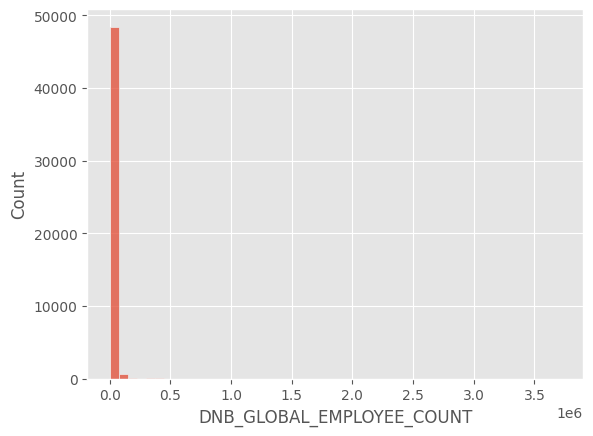

In [440]:
sns.histplot(data=X_train, x="DNB_GLOBAL_EMPLOYEE_COUNT", bins=50)

In [441]:
X_train["DNB_GLOBAL_EMPLOYEE_COUNT"].describe()

count    4.951400e+04
mean     7.545317e+03
std      7.666518e+04
min      2.000000e+00
25%      8.000000e+01
50%      2.600000e+02
75%      1.092000e+03
max      3.715221e+06
Name: DNB_GLOBAL_EMPLOYEE_COUNT, dtype: float64

As the distribution is extremely right tailed imputing I will impute with the median for now. 

In [442]:
employee_count_imputer = SimpleImputer(strategy="median")
employee_count_imputed_vals = employee_count_imputer.fit_transform(
    X_train["DNB_GLOBAL_EMPLOYEE_COUNT"].values.reshape(-1, 1)
)
X_train["DNB_GLOBAL_EMPLOYEE_COUNT"] = employee_count_imputed_vals

As we will need to transform the test set later on, I will save the various imputers used here for future use. 

In [443]:
with open(Path(interim_data_dir, "employee_count_imputer.pkl"), "wb") as f:
    pickle.dump(employee_count_imputer, f)


### Sales Revenue imputation

In [444]:
X_train.select_dtypes("number").corr()["DNB_GLOBAL_SALES_REVENUE"].sort_values()

PRODUCT_NINE                -0.095525
PRODUCT_ONE                 -0.076950
PRODUCT_FIVE                -0.063956
PRODUCT_NINETEEN            -0.037448
PRODUCT_SIX                 -0.031032
                               ...   
ARR                          0.238625
DNB_GLOBAL_EMPLOYEE_COUNT    0.767557
DNB_GLOBAL_SALES_REVENUE     1.000000
PRODUCT_TWENTYONE                 NaN
PRODUCT_TWENTYTWO                 NaN
Name: DNB_GLOBAL_SALES_REVENUE, Length: 72, dtype: float64

Same idea as before, since we have no clear correlation with other features I will investigate the frequency and imputer with either mean or median

<Axes: xlabel='DNB_GLOBAL_SALES_REVENUE', ylabel='Count'>

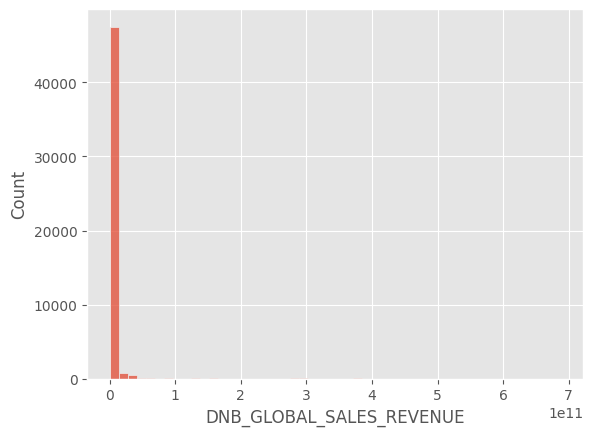

In [445]:
sns.histplot(data=X_train, x="DNB_GLOBAL_SALES_REVENUE", bins=50)

In [446]:
sales_revenue_imputer = SimpleImputer(strategy="median")
sales_revenue_imputed_vals = sales_revenue_imputer.fit_transform(
    X_train["DNB_GLOBAL_SALES_REVENUE"].values.reshape(-1, 1)
)
X_train["DNB_GLOBAL_SALES_REVENUE"] = sales_revenue_imputed_vals

In [447]:
with open(Path(interim_data_dir, "sales_revenue_imputer.pkl"), "wb") as f:
    pickle.dump(sales_revenue_imputer, f)

### Sector Imputation

"Sector" is a categorical feature and so can't be imputed with the mean or median. There are several techniques to handling missing categorical features:
1. Delete the rows with missing data
2. Create a new observation titled "Missing"
3. Fill the most frequent observation

Rows with missing "Sector" data represent around 15% of the entire dataset, so I dont want to delete these and lose a lot of valueable information. 
Similarly missing these in with the mose frequency (mode) value will likely create an over represenation of this class. 
In this case I think the best way to fill these is with a new "missing" example. 

In [448]:
X_train["SECTOR"] = X_train["SECTOR"].fillna("missing")

That should be all of our missing data handled, either dropped completely or imputed, let's check:

In [449]:
X_train.isnull().sum().sum()

0

## Handling Zero ARR

As seen in the EDA, there is an odd pattern of ARR being set to zero when the customer churns. 
I assume this is happening manually as a way of flagging that the customer has left, however unfortunately this encodes information about the customer leaving into the dataset - knowledge we would not usually have at inference time. For this reason I will fill it in with the mean value for each unique user ID. 

In [450]:
ARR_id_means = X_train.groupby("SALESFORCEACCOUNTID", as_index=False).mean(
    numeric_only=True
)[["SALESFORCEACCOUNTID", "ARR"]]
ARR_id_means_dict = dict(zip(ARR_id_means["SALESFORCEACCOUNTID"], ARR_id_means["ARR"]))
ARR_id_means.head()

,SALESFORCEACCOUNTID,ARR
0,0011N00001aYYJiQAO,5275.135789
1,0011N00001aYYJjQAO,2031.436563
2,0011N00001aYYJlQAO,4632.031786
3,0011N00001aYYJmQAO,34178.771667
4,0011N00001aYYJoQAO,1741.261250


In [451]:
def fill_arr_zeroes(
    row: pd.DataFrame, lookup_dict: dict = ARR_id_means_dict
) -> pd.DataFrame:
    if row["ARR"] == 0:
        return lookup_dict[row["SALESFORCEACCOUNTID"]]
    else:
        return row["ARR"]


X_train["ARR"] = X_train.apply(lambda x: fill_arr_zeroes(x), axis=1)

## Transformation
### Fixing Datatypes

Through the EDA it appears most of the columns have reasonable datatypes, however the "ACCOUNTING_MONTH", "RENEWAL_MONTH", and "CONTRACT_START_DATE" need converted to datetime objects so we can do further transformations,. 

In [452]:
X_train.head(2)

,SALESFORCEACCOUNTID,ACCOUNTING_MONTH,RENEWAL_MONTH,CONTRACT_START_DATE,REGION,SECTOR,TENURE_MONTHS,DNB_GLOBAL_SALES_REVENUE,DNB_GLOBAL_EMPLOYEE_COUNT,CONTRACT_LENGTH,ARR,SEATS,COMPETITOR_SEATS,DETECTEDSEATSCOUNT,PRODUCT_ONE,PRODUCT_TWO,PRODUCT_THREE,PRODUCT_FOUR,PRODUCT_FIVE,PRODUCT_SIX,PRODUCT_SEVEN,PRODUCT_EIGHT,PRODUCT_NINE,PRODUCT_TEN,PRODUCT_ELEVEN,PRODUCT_TWELVE,PRODUCT_THIRTEEN,PRODUCT_FOURTEEN,PRODUCT_FIFTEEN,PRODUCT_SIXTEEN,PRODUCT_SEVENTEEN,PRODUCT_EIGHTEEN,PRODUCT_NINETEEN,PRODUCT_TWENTY,PRODUCT_TWENTYONE,PRODUCT_TWENTYTWO,PRODUCT_TWENTYTHREE,LICENSINGSPECIALIST_CHANGE,SALESREP_CHANGE,UPSELLMANAGER_CHANGE,ACCOUNTMANAGER_CHANGE,CHURN_RISK_DISCUSSION,CUSTOMER_HEALTH_CHECK,CS_EVENT_ATTENDED,CROSS_SELL_RECENCY,SEATS_DOWNSELL_RECENCY,PRODUCT_DOWNSELL_RECENCY,SEATS_UPSELL_RECENCY,PCT_PRODUCT_TWO_ENABLED,PCT_PRODUCT_THREE_ENABLED,PCT_PRODUCT_FOUR_ENABLED,PCT_PRODUCT_FIVE_ENABLED,PCT_PRODUCT_SIX_ENABLED,PCT_PRODUCT_NINE_ENABLED,PCT_PRODUCT_TWO_BEST_PRACTICE,PCT_PRODUCT_THREE_BEST_PRACTICE,PCT_PRODUCT_FOUR_BEST_PRACTICE,CUSTOMER_BEHAVIOUR_ONE,CUSTOMER_BEHAVIOUR_TWO,CUSTOMER_BEHAVIOUR_THREE,CUSTOMER_BEHAVIOUR_FOUR,CUSTOMER_BEHAVIOUR_FIVE,CUSTOMER_BEHAVIOUR_SIX,CUSTOMER_BEHAVIOUR_SEVEN,CUSTOMER_BEHAVIOUR_EIGHT,CUSTOMER_BEHAVIOUR_NINE,CUSTOMER_BEHAVIOUR_TEN,CUSTOMER_BEHAVIOUR_ELEVEN,MAX_SUPPORT_CASE_DAYSTOCLOSE,MAX_SUPPORT_CASE_TIMETOFIRSTRESPONSE,AVG_SUPPORT_CASE_PRIORITY_SCORE,SUM_SEVERE_CASES,SUM_HIGH_CASES,SUM_MEDIUM_CASES,SUM_LOW_CASES,SUM_STANDARD_CASES,SUPPORT_CASE_NUMBEROFSLABREACHES,BACKLOG
0,0011N00001aYqEZQA0,2021-06-01 00:00:00+00:00,2022-05-01T00:00:00Z,2021-05-04T00:00:00Z,USA,Finance,52,29283931.0,234.0,364,20418.74,220,0,0.709091,1,1,0,1,1,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,23,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0
1,0011N00001hBZuAQAW,2023-01-01 00:00:00+00:00,2023-12-01T00:00:00Z,2022-12-04T00:00:00Z,UKI,Professional Services,107,260626374.0,2048.0,364,81661.54,800,0,0.736250,1,1,1,1,1,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,12,2,0,0,0,0,0,0,1,1,0,0,14216,16,0,0,2425,5,0,0,109,1,0,0,0.0,0,0,0,0,1,0,3


In [453]:
X_train["ACCOUNTING_MONTH"] = pd.to_datetime(X_train["ACCOUNTING_MONTH"])
X_train["RENEWAL_MONTH"] = pd.to_datetime(X_train["RENEWAL_MONTH"])
X_train["CONTRACT_START_DATE"] = pd.to_datetime(X_train["CONTRACT_START_DATE"])

In [454]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 78 columns):
 #   Column                                Non-Null Count  Dtype              
---  ------                                --------------  -----              
 0   SALESFORCEACCOUNTID                   80000 non-null  object             
 1   ACCOUNTING_MONTH                      80000 non-null  datetime64[ns, UTC]
 2   RENEWAL_MONTH                         80000 non-null  datetime64[ns, UTC]
 3   CONTRACT_START_DATE                   80000 non-null  datetime64[ns, UTC]
 4   REGION                                80000 non-null  object             
 5   SECTOR                                80000 non-null  object             
 6   TENURE_MONTHS                         80000 non-null  int64              
 7   DNB_GLOBAL_SALES_REVENUE              80000 non-null  float64            
 8   DNB_GLOBAL_EMPLOYEE_COUNT             80000 non-null  float64            
 9   CONTRACT_LENGTH  

## Feature Engineering
### Adding TimeBased Columns

In [455]:
TIME_COLS = ["ACCOUNTING_MONTH", "RENEWAL_MONTH", "CONTRACT_START_DATE"]

In [456]:
X_train.sample(5)

,SALESFORCEACCOUNTID,ACCOUNTING_MONTH,RENEWAL_MONTH,CONTRACT_START_DATE,REGION,SECTOR,TENURE_MONTHS,DNB_GLOBAL_SALES_REVENUE,DNB_GLOBAL_EMPLOYEE_COUNT,CONTRACT_LENGTH,ARR,SEATS,COMPETITOR_SEATS,DETECTEDSEATSCOUNT,PRODUCT_ONE,PRODUCT_TWO,PRODUCT_THREE,PRODUCT_FOUR,PRODUCT_FIVE,PRODUCT_SIX,PRODUCT_SEVEN,PRODUCT_EIGHT,PRODUCT_NINE,PRODUCT_TEN,PRODUCT_ELEVEN,PRODUCT_TWELVE,PRODUCT_THIRTEEN,PRODUCT_FOURTEEN,PRODUCT_FIFTEEN,PRODUCT_SIXTEEN,PRODUCT_SEVENTEEN,PRODUCT_EIGHTEEN,PRODUCT_NINETEEN,PRODUCT_TWENTY,PRODUCT_TWENTYONE,PRODUCT_TWENTYTWO,PRODUCT_TWENTYTHREE,LICENSINGSPECIALIST_CHANGE,SALESREP_CHANGE,UPSELLMANAGER_CHANGE,ACCOUNTMANAGER_CHANGE,CHURN_RISK_DISCUSSION,CUSTOMER_HEALTH_CHECK,CS_EVENT_ATTENDED,CROSS_SELL_RECENCY,SEATS_DOWNSELL_RECENCY,PRODUCT_DOWNSELL_RECENCY,SEATS_UPSELL_RECENCY,PCT_PRODUCT_TWO_ENABLED,PCT_PRODUCT_THREE_ENABLED,PCT_PRODUCT_FOUR_ENABLED,PCT_PRODUCT_FIVE_ENABLED,PCT_PRODUCT_SIX_ENABLED,PCT_PRODUCT_NINE_ENABLED,PCT_PRODUCT_TWO_BEST_PRACTICE,PCT_PRODUCT_THREE_BEST_PRACTICE,PCT_PRODUCT_FOUR_BEST_PRACTICE,CUSTOMER_BEHAVIOUR_ONE,CUSTOMER_BEHAVIOUR_TWO,CUSTOMER_BEHAVIOUR_THREE,CUSTOMER_BEHAVIOUR_FOUR,CUSTOMER_BEHAVIOUR_FIVE,CUSTOMER_BEHAVIOUR_SIX,CUSTOMER_BEHAVIOUR_SEVEN,CUSTOMER_BEHAVIOUR_EIGHT,CUSTOMER_BEHAVIOUR_NINE,CUSTOMER_BEHAVIOUR_TEN,CUSTOMER_BEHAVIOUR_ELEVEN,MAX_SUPPORT_CASE_DAYSTOCLOSE,MAX_SUPPORT_CASE_TIMETOFIRSTRESPONSE,AVG_SUPPORT_CASE_PRIORITY_SCORE,SUM_SEVERE_CASES,SUM_HIGH_CASES,SUM_MEDIUM_CASES,SUM_LOW_CASES,SUM_STANDARD_CASES,SUPPORT_CASE_NUMBEROFSLABREACHES,BACKLOG
52635,0011N00001aYhHhQAK,2022-03-01 00:00:00+00:00,2022-07-01 00:00:00+00:00,2021-07-04 00:00:00+00:00,UKI,Professional Services,44,2.676676e+07,158.0,364,6285.18,99,0,0.575758,1,1,1,1,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,7,19,8,0,0,0,0,0,0,1,1,0,0,7096,0,0,0,641,141,0,0,24,0,0,0,0.0,0,0,0,0,0,0,0
71047,0011N00001iNUxVQAW,2022-05-01 00:00:00+00:00,2023-01-01 00:00:00+00:00,2022-01-22 00:00:00+00:00,USA,Professional Services,37,4.523423e+06,35.0,364,3102.99,99,0,0.676768,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,4,0,0,0,0,0,0,0,0,0,0,14048,0,0,0,1231,84,1,1,6,0,0,0,0.0,0,0,0,0,0,0,0
9622,0011N00001aYuuxQAC,2020-02-01 00:00:00+00:00,2020-07-01 00:00:00+00:00,2019-07-20 00:00:00+00:00,USA,Retail & Wholesale,22,1.724429e+08,1077.0,365,39300.00,800,0,0.756250,1,1,1,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,1,0,0
29824,0011N00001hBZu8QAG,2020-08-01 00:00:00+00:00,2020-09-01 00:00:00+00:00,2019-09-29 00:00:00+00:00,UKI,Professional Services,86,5.571998e+07,260.0,365,22442.28,183,158,0.939891,1,1,1,1,1,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,10,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,2,0,0
13275,0011N00001aYYObQAO,2023-04-01 00:00:00+00:00,2024-10-01 00:00:00+00:00,2022-10-31 00:00:00+00:00,RSA,Retail & Wholesale,137,6.029326e+09,11992.0,730,148558.46,3500,0,0.000000,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,6,5,5,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,44,0,0,27,0,0,0.0,0,0,0,0,0,0,4


Now I want to add some new features such as "DAYS_FROM_CONTRACT_START", and "DAYS_TO_CONTRACT_END". The intuitiion is this will give us provide helpful information in predicting churn 12 months in advance. 

In [457]:
X_train["DAYS_TO_CONTRACT_END"] = pd.to_timedelta(
    (X_train["RENEWAL_MONTH"] - X_train["ACCOUNTING_MONTH"]).values
).days
X_train["DAYS_FROM_CONTRACT_START"] = pd.to_timedelta(
    (X_train["ACCOUNTING_MONTH"] - X_train["CONTRACT_START_DATE"]).values
).days

In [458]:
X_train.sample(5)

,SALESFORCEACCOUNTID,ACCOUNTING_MONTH,RENEWAL_MONTH,CONTRACT_START_DATE,REGION,SECTOR,TENURE_MONTHS,DNB_GLOBAL_SALES_REVENUE,DNB_GLOBAL_EMPLOYEE_COUNT,CONTRACT_LENGTH,ARR,SEATS,COMPETITOR_SEATS,DETECTEDSEATSCOUNT,PRODUCT_ONE,PRODUCT_TWO,PRODUCT_THREE,PRODUCT_FOUR,PRODUCT_FIVE,PRODUCT_SIX,PRODUCT_SEVEN,PRODUCT_EIGHT,PRODUCT_NINE,PRODUCT_TEN,PRODUCT_ELEVEN,PRODUCT_TWELVE,PRODUCT_THIRTEEN,PRODUCT_FOURTEEN,PRODUCT_FIFTEEN,PRODUCT_SIXTEEN,PRODUCT_SEVENTEEN,PRODUCT_EIGHTEEN,PRODUCT_NINETEEN,PRODUCT_TWENTY,PRODUCT_TWENTYONE,PRODUCT_TWENTYTWO,PRODUCT_TWENTYTHREE,LICENSINGSPECIALIST_CHANGE,SALESREP_CHANGE,UPSELLMANAGER_CHANGE,ACCOUNTMANAGER_CHANGE,CHURN_RISK_DISCUSSION,CUSTOMER_HEALTH_CHECK,CS_EVENT_ATTENDED,CROSS_SELL_RECENCY,SEATS_DOWNSELL_RECENCY,PRODUCT_DOWNSELL_RECENCY,SEATS_UPSELL_RECENCY,PCT_PRODUCT_TWO_ENABLED,PCT_PRODUCT_THREE_ENABLED,PCT_PRODUCT_FOUR_ENABLED,PCT_PRODUCT_FIVE_ENABLED,PCT_PRODUCT_SIX_ENABLED,PCT_PRODUCT_NINE_ENABLED,PCT_PRODUCT_TWO_BEST_PRACTICE,PCT_PRODUCT_THREE_BEST_PRACTICE,PCT_PRODUCT_FOUR_BEST_PRACTICE,CUSTOMER_BEHAVIOUR_ONE,CUSTOMER_BEHAVIOUR_TWO,CUSTOMER_BEHAVIOUR_THREE,CUSTOMER_BEHAVIOUR_FOUR,CUSTOMER_BEHAVIOUR_FIVE,CUSTOMER_BEHAVIOUR_SIX,CUSTOMER_BEHAVIOUR_SEVEN,CUSTOMER_BEHAVIOUR_EIGHT,CUSTOMER_BEHAVIOUR_NINE,CUSTOMER_BEHAVIOUR_TEN,CUSTOMER_BEHAVIOUR_ELEVEN,MAX_SUPPORT_CASE_DAYSTOCLOSE,MAX_SUPPORT_CASE_TIMETOFIRSTRESPONSE,AVG_SUPPORT_CASE_PRIORITY_SCORE,SUM_SEVERE_CASES,SUM_HIGH_CASES,SUM_MEDIUM_CASES,SUM_LOW_CASES,SUM_STANDARD_CASES,SUPPORT_CASE_NUMBEROFSLABREACHES,BACKLOG,DAYS_TO_CONTRACT_END,DAYS_FROM_CONTRACT_START
62828,0011N00001aYYNzQAO,2021-08-01 00:00:00+00:00,2022-06-01 00:00:00+00:00,2021-06-30 00:00:00+00:00,RSA,IT,37,55719979.0,260.0,364,2847.56,1,0,32.000000,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,6,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,304,32
69967,0011N00001hBZMFQA4,2021-04-01 00:00:00+00:00,2024-03-01 00:00:00+00:00,2021-03-23 00:00:00+00:00,UKI,Finance,102,436021669.0,4115.0,1095,129647.33,4000,0,0.000000,1,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50,70.0,0,0,0,0,1,0,0,1065,9
16060,0013l000021v1IYAAY,2021-07-01 00:00:00+00:00,2021-12-01 00:00:00+00:00,2020-12-13 00:00:00+00:00,DACH,Manufacturing,19,117771475.0,844.0,364,3758.14,35,0,0.485714,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,6,0,3,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,153,200
3138,0011N00001aYYJuQAO,2021-07-01 00:00:00+00:00,2022-03-01 00:00:00+00:00,2021-03-30 00:00:00+00:00,RSA,Retail & Wholesale,27,6380569.0,17.0,364,2605.12,70,0,0.928571,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,243,93
69948,0011N00001aYqCyQAK,2021-07-01 00:00:00+00:00,2021-11-01 00:00:00+00:00,2020-11-25 00:00:00+00:00,USA,Mining & Extraction,65,86065229.0,561.0,364,33820.88,360,0,0.450000,1,1,0,0,1,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,8,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,123,218


## Breaking out time features

Going to break the yyyy-mm-dd columns into specific year, month, day cols as this will make encoding later easier

In [459]:
# Years
X_train["ACCOUNTING_YEAR"] = X_train["ACCOUNTING_MONTH"].dt.year
X_train["RENEWAL_YEAR"] = X_train["RENEWAL_MONTH"].dt.year
X_train["CONTRACT_START_DATE_YEAR"] = X_train["CONTRACT_START_DATE"].dt.year
# Days - Most of these are just 1 but I'll handle this later when inspecting number of unique vals per col
X_train["ACCOUNTING_DAY"] = X_train["ACCOUNTING_MONTH"].dt.day
X_train["RENEWAL_DAY"] = X_train["RENEWAL_MONTH"].dt.day
X_train["CONTRACT_START_DATE_DAY"] = X_train["CONTRACT_START_DATE"].dt.day

# Months
X_train["ACCOUNTING_MONTH"] = X_train["ACCOUNTING_MONTH"].dt.month
X_train["RENEWAL_MONTH"] = X_train["RENEWAL_MONTH"].dt.month
X_train["CONTRACT_START_DATE_MONTH"] = X_train["CONTRACT_START_DATE"].dt.month

X_train = X_train.drop("CONTRACT_START_DATE", axis=1)

In [460]:
X_train.sample(5)

,SALESFORCEACCOUNTID,ACCOUNTING_MONTH,RENEWAL_MONTH,REGION,SECTOR,TENURE_MONTHS,DNB_GLOBAL_SALES_REVENUE,DNB_GLOBAL_EMPLOYEE_COUNT,CONTRACT_LENGTH,ARR,SEATS,COMPETITOR_SEATS,DETECTEDSEATSCOUNT,PRODUCT_ONE,PRODUCT_TWO,PRODUCT_THREE,PRODUCT_FOUR,PRODUCT_FIVE,PRODUCT_SIX,PRODUCT_SEVEN,PRODUCT_EIGHT,PRODUCT_NINE,PRODUCT_TEN,PRODUCT_ELEVEN,PRODUCT_TWELVE,PRODUCT_THIRTEEN,PRODUCT_FOURTEEN,PRODUCT_FIFTEEN,PRODUCT_SIXTEEN,PRODUCT_SEVENTEEN,PRODUCT_EIGHTEEN,PRODUCT_NINETEEN,PRODUCT_TWENTY,PRODUCT_TWENTYONE,PRODUCT_TWENTYTWO,PRODUCT_TWENTYTHREE,LICENSINGSPECIALIST_CHANGE,SALESREP_CHANGE,UPSELLMANAGER_CHANGE,ACCOUNTMANAGER_CHANGE,CHURN_RISK_DISCUSSION,CUSTOMER_HEALTH_CHECK,CS_EVENT_ATTENDED,CROSS_SELL_RECENCY,SEATS_DOWNSELL_RECENCY,PRODUCT_DOWNSELL_RECENCY,SEATS_UPSELL_RECENCY,PCT_PRODUCT_TWO_ENABLED,PCT_PRODUCT_THREE_ENABLED,PCT_PRODUCT_FOUR_ENABLED,PCT_PRODUCT_FIVE_ENABLED,PCT_PRODUCT_SIX_ENABLED,PCT_PRODUCT_NINE_ENABLED,PCT_PRODUCT_TWO_BEST_PRACTICE,PCT_PRODUCT_THREE_BEST_PRACTICE,PCT_PRODUCT_FOUR_BEST_PRACTICE,CUSTOMER_BEHAVIOUR_ONE,CUSTOMER_BEHAVIOUR_TWO,CUSTOMER_BEHAVIOUR_THREE,CUSTOMER_BEHAVIOUR_FOUR,CUSTOMER_BEHAVIOUR_FIVE,CUSTOMER_BEHAVIOUR_SIX,CUSTOMER_BEHAVIOUR_SEVEN,CUSTOMER_BEHAVIOUR_EIGHT,CUSTOMER_BEHAVIOUR_NINE,CUSTOMER_BEHAVIOUR_TEN,CUSTOMER_BEHAVIOUR_ELEVEN,MAX_SUPPORT_CASE_DAYSTOCLOSE,MAX_SUPPORT_CASE_TIMETOFIRSTRESPONSE,AVG_SUPPORT_CASE_PRIORITY_SCORE,SUM_SEVERE_CASES,SUM_HIGH_CASES,SUM_MEDIUM_CASES,SUM_LOW_CASES,SUM_STANDARD_CASES,SUPPORT_CASE_NUMBEROFSLABREACHES,BACKLOG,DAYS_TO_CONTRACT_END,DAYS_FROM_CONTRACT_START,ACCOUNTING_YEAR,RENEWAL_YEAR,CONTRACT_START_DATE_YEAR,ACCOUNTING_DAY,RENEWAL_DAY,CONTRACT_START_DATE_DAY,CONTRACT_START_DATE_MONTH
46011,0013l00002Kf2yeAAB,8,6,USA,missing,2,1.500405e+08,1125.0,1095,78285.99,2000,0,0.143500,1,0,0,0,1,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,49,466,70.0,0,0,0,1,3,1,1,1035,47,2021,2024,2021,1,1,15,6
71551,0011N00001hBZuAQAW,10,12,UKI,Professional Services,80,2.606264e+08,2048.0,358,62767.62,800,0,0.676250,1,1,1,1,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,10,9,9,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,61,295,2020,2020,2019,1,1,11,12
7853,0011N00001aYqJFQA0,7,8,USA,Finance,51,3.930642e+07,70.0,364,30904.75,150,0,0.813333,1,1,1,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,10,0,11,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,1,0,0,31,304,2021,2021,2020,1,1,31,8
3610,0011N00001aYkI6QAK,12,5,UKI,Finance,33,2.193521e+10,6994.0,364,25482.77,241,0,0.946058,1,1,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,7,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,151,186,2021,2022,2021,1,1,29,5
34740,0013l00002KfNpHAAV,12,5,UKI,missing,24,7.980221e+07,519.0,364,9558.25,150,0,0.760000,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,7,0,0,0,0,0,0,0,0,0,0,12594,0,0,0,1157,48,0,0,50,0,0,0,0.0,0,0,0,0,0,0,2,151,199,2022,2023,2022,1,1,16,5


### Cirular Transformation of cyclical time features

Features such as day of the month, month of the year, and hour of the day are cyclical in nature and need to be encoded this way. 

Looking at month of the year for example - 12 (Dec) is naturally close to 1 (Jan) in the calendar, but are far away from each other when considered as raw values. By applying a cosine or sine transformation to these we can tell the model they are actually near each other. We can visualize this effect with seaborn

In [461]:
X_train["RENEWAL_MONTH_SIN"] = X_train["RENEWAL_MONTH"].apply(
    lambda x: np.sin(x / 12 * 2 * np.pi)
)
X_train["RENEWAL_MONTH_COS"] = X_train["RENEWAL_MONTH"].apply(
    lambda x: np.cos(x / 12 * 2 * np.pi)
)

X_train["ACCOUNTING_MONTH_SIN"] = X_train["ACCOUNTING_MONTH"].apply(
    lambda x: np.sin(x / 12 * 2 * np.pi)
)
X_train["ACCOUNTING_MONTH_COS"] = X_train["ACCOUNTING_MONTH"].apply(
    lambda x: np.cos(x / 12 * 2 * np.pi)
)


X_train["CONTRACT_START_DATE_MONTH_SIN"] = X_train["CONTRACT_START_DATE_MONTH"].apply(
    lambda x: np.sin(x / 12 * 2 * np.pi)
)
X_train["CONTRACT_START_DATE_MONTH_COS"] = X_train["CONTRACT_START_DATE_MONTH"].apply(
    lambda x: np.cos(x / 12 * 2 * np.pi)
)

X_train["CONTRACT_START_DATE_DAY_SIN"] = X_train["CONTRACT_START_DATE_DAY"].apply(
    lambda x: np.sin(x / 30 * 2 * np.pi)
)
X_train["CONTRACT_START_DATE_DAY_COS"] = X_train["CONTRACT_START_DATE_DAY"].apply(
    lambda x: np.cos(x / 30 * 2 * np.pi)
)

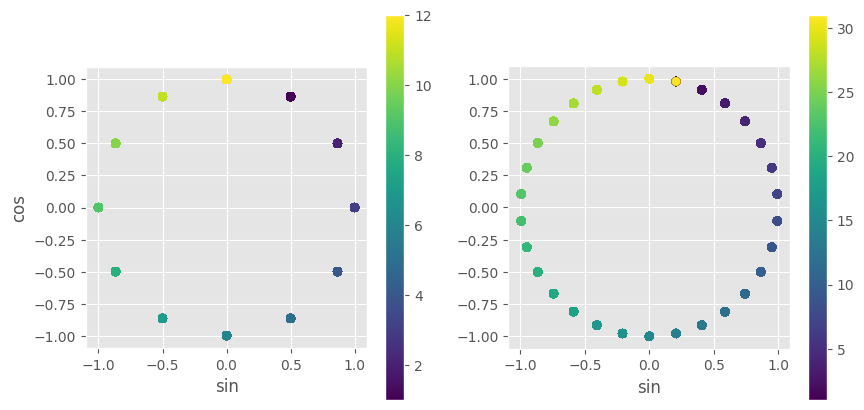

In [462]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
axes = np.ravel(ax)
sp = axes[0].scatter(
    X_train["CONTRACT_START_DATE_MONTH_SIN"],
    X_train["CONTRACT_START_DATE_MONTH_COS"],
    c=X_train["CONTRACT_START_DATE_MONTH"],
)
axes[0].set(
    xlabel="sin",
    ylabel="cos",
)
_ = fig.colorbar(sp)
sp = axes[1].scatter(
    X_train["CONTRACT_START_DATE_DAY_SIN"],
    X_train["CONTRACT_START_DATE_DAY_COS"],
    c=X_train["CONTRACT_START_DATE_DAY"],
)
axes[1].set(
    xlabel="sin",
    ylabel="",
)
_ = fig.colorbar(sp)
axes[0].set_aspect("equal")
axes[1].set_aspect("equal")

Now the model knows that 12 (Dec) shoud be considered close to 1 (Jan). 
Note we've decomposed each time feature into two seperate ones - Sin and Cos. This is to avoid the problem of having two different x values equalling the same sin(x) value. 
i.e sin(0) = sin(pi)

## Removing useless features

The previously decomposed time based features can be removed now they exist as two seperate features

In [463]:
X_train = X_train.drop(
    [
        "ACCOUNTING_MONTH",
        "RENEWAL_MONTH",
        "CONTRACT_START_DATE_MONTH",
        "CONTRACT_START_DATE_DAY",
    ],
    axis=1,
)

Features that do not have enough varience within them are not useful for modelling and can be removed. 

In [464]:
pd.DataFrame(X_train.apply(lambda x: x.nunique(), axis=0).sort_values()).head(10)

,0
PRODUCT_TWENTYTWO,1
ACCOUNTING_DAY,1
PRODUCT_TWENTYONE,1
RENEWAL_DAY,1
PCT_PRODUCT_FOUR_ENABLED,2
PCT_PRODUCT_THREE_ENABLED,2
PRODUCT_TWENTY,2
PRODUCT_NINETEEN,2
PRODUCT_EIGHTEEN,2
PRODUCT_ELEVEN,2


As suspected the day component of the time data is often just 1, however it's surprising to see two other columns also have no variance. 

In [465]:
X_train["PRODUCT_TWENTYONE"].unique(), X_train["PRODUCT_TWENTYTWO"].unique()

(array([0], dtype=int64), array([0], dtype=int64))

In [466]:
X_train = X_train.drop(
    ["RENEWAL_DAY", "ACCOUNTING_DAY", "PRODUCT_TWENTYONE", "PRODUCT_TWENTYTWO"], axis=1
)

Another thing to consider is categorical features that have very high cardinality, as encoding these may cause problems with too many features. 

In [467]:
pd.DataFrame(
    X_train.select_dtypes(exclude="number")
    .apply(lambda x: x.nunique(), axis=0)
    .sort_values()
).head(10)

,0
REGION,9
SECTOR,23
SALESFORCEACCOUNTID,3334


The accountID shouldn't have any influence on the likelihood of custumer churn, as this is just a unique identifier assigned at random, therefore we can drop this. 
The other categorical features don't have extremely high varience so we can transform these with one hot encoding or other techniques later. 

In [468]:
X_train = X_train.drop("SALESFORCEACCOUNTID", axis=1)

### Scaling

We are not interesting in scaling features which already exist between -1 and 1 (bool features, percentages etc). I will extract the columns that do not fit this criteria, scale, and re add to the entire dataset

In [469]:
X_numeric = X_train.select_dtypes("number")
to_scale_cols = []
for col in X_numeric.columns:
    if not X_numeric[col].between(-1, 1).all():
        to_scale_cols.append(col)

X_to_scale = X_train[to_scale_cols]

In [470]:
X_to_scale.describe()

,TENURE_MONTHS,DNB_GLOBAL_SALES_REVENUE,DNB_GLOBAL_EMPLOYEE_COUNT,CONTRACT_LENGTH,ARR,SEATS,COMPETITOR_SEATS,DETECTEDSEATSCOUNT,LICENSINGSPECIALIST_CHANGE,ACCOUNTMANAGER_CHANGE,CHURN_RISK_DISCUSSION,CUSTOMER_HEALTH_CHECK,CS_EVENT_ATTENDED,CROSS_SELL_RECENCY,SEATS_DOWNSELL_RECENCY,PRODUCT_DOWNSELL_RECENCY,SEATS_UPSELL_RECENCY,CUSTOMER_BEHAVIOUR_ONE,CUSTOMER_BEHAVIOUR_TWO,CUSTOMER_BEHAVIOUR_THREE,CUSTOMER_BEHAVIOUR_SIX,CUSTOMER_BEHAVIOUR_SEVEN,CUSTOMER_BEHAVIOUR_EIGHT,CUSTOMER_BEHAVIOUR_NINE,CUSTOMER_BEHAVIOUR_TEN,CUSTOMER_BEHAVIOUR_ELEVEN,MAX_SUPPORT_CASE_DAYSTOCLOSE,MAX_SUPPORT_CASE_TIMETOFIRSTRESPONSE,AVG_SUPPORT_CASE_PRIORITY_SCORE,SUM_SEVERE_CASES,SUM_HIGH_CASES,SUM_MEDIUM_CASES,SUM_LOW_CASES,SUM_STANDARD_CASES,SUPPORT_CASE_NUMBEROFSLABREACHES,BACKLOG,DAYS_TO_CONTRACT_END,DAYS_FROM_CONTRACT_START,ACCOUNTING_YEAR,RENEWAL_YEAR,CONTRACT_START_DATE_YEAR
count,80000.000000,8.000000e+04,8.000000e+04,80000.000000,8.000000e+04,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.00000,80000.000000,80000.000000,8.000000e+04,80000.000000,8.000000e+04,8.000000e+04,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000
mean,43.087438,1.923163e+09,4.769065e+03,394.311500,2.509859e+04,841.738450,80.134625,0.677210,0.127213,0.046462,0.002988,0.014850,0.151613,3.183025,4.126163,1.47875,4.144213,0.016950,3.949145e+04,4.236338,1.543466e+03,8.776418e+02,5.845675,29.035500,128.717437,3.340663,3.384162,232.066763,11.517516,0.000287,0.001512,0.000775,0.005875,0.692013,0.112875,0.715975,224.945550,149.784825,2021.210875,2021.769400,2020.693487
std,33.484632,1.806906e+10,6.041733e+04,189.450125,7.899297e+04,5197.460714,557.112196,5.076816,0.333325,0.210605,0.072482,0.137494,0.707978,7.026081,4.354849,5.36778,4.199579,1.204266,1.602918e+06,57.904360,1.323394e+04,1.966345e+04,56.979198,732.960223,3561.403264,65.054891,20.130446,1383.410812,26.306222,0.019037,0.046478,0.032006,0.083310,1.503283,0.450346,3.959552,187.514659,130.637664,0.972236,1.132537,1.038172
min,-1.000000,1.000000e+00,2.000000e+00,-1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-821.000000,-45.000000,2020.000000,2019.000000,2019.000000
25%,21.000000,3.338075e+07,1.700000e+02,364.000000,3.384970e+03,50.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,92.000000,47.000000,2020.000000,2021.000000,2020.000000
50%,35.000000,5.571998e+07,2.600000e+02,364.000000,8.986000e+03,150.000000,0.000000,0.625231,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.00000,3.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,212.000000,135.000000,2021.000000,2022.000000,2021.000000
75%,52.000000,9.071812e+07,4.120000e+02,364.000000,2.328151e+04,445.000000,2.000000,0.873674,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,7.000000,0.00000,7.000000,0.000000,5.933250e+03,0.000000,4.120000e+02,1.000000e+00,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,304.000000,240.250000,2022.000000,2023.000000,2022.000000
max,191.000000,6.876680e+11,3.715221e+06,3652.000000,2.724687e+06,167001.000000,31101.000000,649.50000

In [471]:
scaler = MinMaxScaler()
scaled_X = pd.DataFrame(columns=to_scale_cols, data=scaler.fit_transform(X_to_scale))
scaled_X.sample(5)

,TENURE_MONTHS,DNB_GLOBAL_SALES_REVENUE,DNB_GLOBAL_EMPLOYEE_COUNT,CONTRACT_LENGTH,ARR,SEATS,COMPETITOR_SEATS,DETECTEDSEATSCOUNT,LICENSINGSPECIALIST_CHANGE,ACCOUNTMANAGER_CHANGE,CHURN_RISK_DISCUSSION,CUSTOMER_HEALTH_CHECK,CS_EVENT_ATTENDED,CROSS_SELL_RECENCY,SEATS_DOWNSELL_RECENCY,PRODUCT_DOWNSELL_RECENCY,SEATS_UPSELL_RECENCY,CUSTOMER_BEHAVIOUR_ONE,CUSTOMER_BEHAVIOUR_TWO,CUSTOMER_BEHAVIOUR_THREE,CUSTOMER_BEHAVIOUR_SIX,CUSTOMER_BEHAVIOUR_SEVEN,CUSTOMER_BEHAVIOUR_EIGHT,CUSTOMER_BEHAVIOUR_NINE,CUSTOMER_BEHAVIOUR_TEN,CUSTOMER_BEHAVIOUR_ELEVEN,MAX_SUPPORT_CASE_DAYSTOCLOSE,MAX_SUPPORT_CASE_TIMETOFIRSTRESPONSE,AVG_SUPPORT_CASE_PRIORITY_SCORE,SUM_SEVERE_CASES,SUM_HIGH_CASES,SUM_MEDIUM_CASES,SUM_LOW_CASES,SUM_STANDARD_CASES,SUPPORT_CASE_NUMBEROFSLABREACHES,BACKLOG,DAYS_TO_CONTRACT_END,DAYS_FROM_CONTRACT_START,ACCOUNTING_YEAR,RENEWAL_YEAR,CONTRACT_START_DATE_YEAR
17565,0.072917,0.000076,0.000167,0.099918,0.004738,0.001108,0.000000,0.001307,0.5,0.0,0.000000,0.0,0.000000,0.0,0.028571,0.0,0.055556,0.0,0.000068,0.000000,0.000518,0.000025,0.000000,0.000000,0.000047,0.000150,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.003984,0.256732,0.051095,0.666667,0.4,0.75
72872,0.885417,0.002217,0.000050,0.099918,0.012836,0.003653,0.000000,0.001302,0.0,0.0,0.000000,0.0,0.016667,0.0,0.142857,0.0,0.166667,0.0,0.000217,0.006012,0.004210,0.000075,0.001065,0.000168,0.001690,0.000901,0.039548,0.032758,0.333333,0.0,0.0,0.0,0.0,0.051724,0.142857,0.011952,0.229347,0.130723,0.666667,0.3,0.50
15233,0.130208,0.000081,0.000069,0.099918,0.000522,0.000293,0.000193,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.270653,0.021234,0.333333,0.3,0.50
55626,0.526042,0.000081,0.000069,0.142075,0.493576,0.176646,0.010611,0.000123,0.0,0.0,0.166667,0.0,0.033333,0.0,0.342857,0.0,0.361111,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.034483,0.000000,0.000000,0.215427,0.274718,0.000000,0.2,0.00
49860,0.125000,0.000081,0.000069,0.099918,0.001850,0.000599,0.000643,0.001339,0.5,0.0,0.000000,0.0,0.000000,0.0,0.314286,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.008621,0.000000,0.000000,0.270653,0.013935,0.333333,0.3,0.50


In [472]:
# As with previous imputers, saving the scaler for future test set transformation
with open(Path(interim_data_dir, "scaler.pkl"), "wb") as f:
    pickle.dump(scaler, f)

In [473]:
X_train = X_train.drop(to_scale_cols, axis=1, errors="ignore")
X_train = pd.concat(
    [X_train.reset_index(drop=True), scaled_X.reset_index(drop=True)], axis=1
)

In [474]:
X_train.sample(5)

,REGION,SECTOR,PRODUCT_ONE,PRODUCT_TWO,PRODUCT_THREE,PRODUCT_FOUR,PRODUCT_FIVE,PRODUCT_SIX,PRODUCT_SEVEN,PRODUCT_EIGHT,PRODUCT_NINE,PRODUCT_TEN,PRODUCT_ELEVEN,PRODUCT_TWELVE,PRODUCT_THIRTEEN,PRODUCT_FOURTEEN,PRODUCT_FIFTEEN,PRODUCT_SIXTEEN,PRODUCT_SEVENTEEN,PRODUCT_EIGHTEEN,PRODUCT_NINETEEN,PRODUCT_TWENTY,PRODUCT_TWENTYTHREE,SALESREP_CHANGE,UPSELLMANAGER_CHANGE,PCT_PRODUCT_TWO_ENABLED,PCT_PRODUCT_THREE_ENABLED,PCT_PRODUCT_FOUR_ENABLED,PCT_PRODUCT_FIVE_ENABLED,PCT_PRODUCT_SIX_ENABLED,PCT_PRODUCT_NINE_ENABLED,PCT_PRODUCT_TWO_BEST_PRACTICE,PCT_PRODUCT_THREE_BEST_PRACTICE,PCT_PRODUCT_FOUR_BEST_PRACTICE,CUSTOMER_BEHAVIOUR_FOUR,CUSTOMER_BEHAVIOUR_FIVE,RENEWAL_MONTH_SIN,RENEWAL_MONTH_COS,ACCOUNTING_MONTH_SIN,ACCOUNTING_MONTH_COS,CONTRACT_START_DATE_MONTH_SIN,CONTRACT_START_DATE_MONTH_COS,CONTRACT_START_DATE_DAY_SIN,CONTRACT_START_DATE_DAY_COS,TENURE_MONTHS,DNB_GLOBAL_SALES_REVENUE,DNB_GLOBAL_EMPLOYEE_COUNT,CONTRACT_LENGTH,ARR,SEATS,COMPETITOR_SEATS,DETECTEDSEATSCOUNT,LICENSINGSPECIALIST_CHANGE,ACCOUNTMANAGER_CHANGE,CHURN_RISK_DISCUSSION,CUSTOMER_HEALTH_CHECK,CS_EVENT_ATTENDED,CROSS_SELL_RECENCY,SEATS_DOWNSELL_RECENCY,PRODUCT_DOWNSELL_RECENCY,SEATS_UPSELL_RECENCY,CUSTOMER_BEHAVIOUR_ONE,CUSTOMER_BEHAVIOUR_TWO,CUSTOMER_BEHAVIOUR_THREE,CUSTOMER_BEHAVIOUR_SIX,CUSTOMER_BEHAVIOUR_SEVEN,CUSTOMER_BEHAVIOUR_EIGHT,CUSTOMER_BEHAVIOUR_NINE,CUSTOMER_BEHAVIOUR_TEN,CUSTOMER_BEHAVIOUR_ELEVEN,MAX_SUPPORT_CASE_DAYSTOCLOSE,MAX_SUPPORT_CASE_TIMETOFIRSTRESPONSE,AVG_SUPPORT_CASE_PRIORITY_SCORE,SUM_SEVERE_CASES,SUM_HIGH_CASES,SUM_MEDIUM_CASES,SUM_LOW_CASES,SUM_STANDARD_CASES,SUPPORT_CASE_NUMBEROFSLABREACHES,BACKLOG,DAYS_TO_CONTRACT_END,DAYS_FROM_CONTRACT_START,ACCOUNTING_YEAR,RENEWAL_YEAR,CONTRACT_START_DATE_YEAR
42811,RSA,Finance,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,-0.866025,0.500000,1.224647e-16,-1.000000e+00,-0.500000,0.866025,2.079117e-01,0.978148,0.848958,0.000014,0.000012,0.099918,0.001677,0.000293,0.000000,0.000660,0.0,0.0,0.0,0.0,0.0,0.000000,0.171429,0.000000,0.194444,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.215199,0.170537,0.333333,0.2,0.25
63152,RSA,Government,1,1,1,1,1,1,0,0,1,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,-0.500000,0.866025,8.660254e-01,-5.000000e-01,0.866025,-0.500000,-2.449294e-16,1.000000,0.609375,0.000081,0.000069,0.258691,0.004821,0.000599,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.255319,0.314286,0.000000,0.305556,0.0,0.000000,0.000000,0.000000,0.0,0.000237,0.000000,0.000000,0.000601,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.015936,0.319717,0.252820,1.000000,0.5,0.75
68500,RSA,Retail & Wholesale,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.500000,0.866025,1.000000e+00,6.123234e-17,0.500000,0.866025,2.079117e-01,0.978148,0.578125,0.000007,0.000011,0.099918,0.006440,0.001557,0.000000,0.001149,0.0,0.0,0.0,0.0,0.0,0.553191,0.028571,0.489796,0.055556,0.0,0.000363,0.001781,0.001883,0.0,0.000473,0.000069,0.000195,0.000150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.257188,0.049104,0.666667,0.4,0.75
1279,USA,Professional Services,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.866025,0.500000,-5.000000e-01,-8.660254e-01,-0.866025,0.500000,-4.067366e-01,0.913545,0.114583,0.000167,0.000112,0.100192,0.005282,0.003533,0.011125,0.000921,0.0,0.5,0.0,0.0,0.0,0.000000,0.085714,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017241,0.0,0.000000,0.208352,0.193762,0.000000,0.1,0.00
58257,USA,Professional Services,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.500000,-0.866025,5.000000e-01,-8.660254e-01,0.500000,-0.866025,-9.945219e-01,0.104528,0.119792,0.000081,0.000069,0.099918,0.005285,0.007186,0.000000,0.000000,0.0,0.5,0.0,0.0,0.0,0.000000,0.028571,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0

## Categorical Features

There are several ways to convert categorical features to numeric values:
1. One hot encoding
2. Ordinal Encoding
3. Word Embeddings

OHE is the most common and works well if the cardinality of the data isnt too high. 

Ordinal enocding only makes sense when there is some order to the categories (i.e "good", "bad", "excellent"). This doesnt apply here

Word embeddings might work well especially for capturing sectors that are similar (i,e IT and Tech), and is something I would like to investigating in future. 

In [475]:
X_train_categorical = X_train.select_dtypes(exclude="number")
X_train = X_train.drop(X_train_categorical.columns, axis=1)

In [476]:
enc = OneHotEncoder(handle_unknown="ignore")
enc.fit(X_train_categorical)
enc.transform(X_train_categorical)
ohe_vals = enc.transform(X_train_categorical).toarray()
X_train_categorical_ohe = pd.DataFrame(
    columns=enc.get_feature_names_out(), data=ohe_vals
)

In [477]:
with open(Path(interim_data_dir, "OHE.pkl"), "wb") as f:
    pickle.dump(enc, f)

In [478]:
X_train = pd.concat(
    [X_train.reset_index(drop=True), X_train_categorical_ohe.reset_index(drop=True)],
    axis=1,
)

Checking final shape of data and double checking for missing values. 

In [479]:
X_train.shape

(80000, 115)

In [480]:
X_train.isnull().sum().sum()

0

# Saving

Data Cleaning and transformation is complete (for now) and I will save the X_train and y_train data for modelling in another file. 
I will convert the transformations undertaken here into a pipeline for efficient re-running and for application to the test set when I am happy with the CV results. 

In [481]:
X_train.to_pickle(Path(processed_data_dir, "X_train_transformed.pkl"))